### Rendering map 

For considering the map here we consider the following extensions 

- [ipyleaflef](https://ipyleaflet.readthedocs.io/en/latest/installation.html)
- [gmplot](https://github.com/vgm64/gmplot)

In [1]:
import os
from scipy.io import loadmat

import pandas as pd 
import numpy as np 
import dask.array as da 
import dask.dataframe as dd

from datetime import datetime, timedelta

import matplotlib.pyplot as plt 

# Maps
from ipyleaflet import Marker, Map
from gmplot import gmplot

from matplotlib import rc 

# Uncomment to export LaTeX
# rc('font',**{'family':'serif','serif':['Times']})
# rc('text', usetex=True)

Loading all data

In [2]:
data_dir_list = ('..','raw','20160316_061540_DE477VE_Description.mat')
kernel_path = os.getcwd()
data_dir_path = os.path.join(kernel_path,*data_dir_list)
dct_data = loadmat(data_dir_path, matlab_compatible= True, squeeze_me = True)

List of all posible variables

In [3]:
varname_lst = []    
for fld in dct_data['DAY'].dtype.fields:
    varname_lst.append(fld)

Extracting all position data

In [4]:
gps_var = ['DATE_HOUR_GPS', 'LATITUDE', 'LONGITUDE','ALTITUDE','SLOPE']
lst_gps = [data.transpose()[0].transpose() for var, data in zip(varname_lst, dct_data['DAY'][0][0]) if var in gps_var]

Cleaning the list of values. Droping out all `nan`

In [5]:
gps_flt = [row for row in zip(*lst_gps) if not np.isnan(row).any()]

Transform into data frame 

In [6]:
gps_df = pd.DataFrame(gps_flt, columns = gps_var)

In [7]:
gps_df = gps_df.drop_duplicates()

Transform the date 

In [8]:
def transform_date(matlab_datenum):
    """ Convert a date to datetime """
    python_datetime = datetime.fromordinal(int(matlab_datenum)) + timedelta(days=matlab_datenum%1) - timedelta(days = 366)
    return python_datetime

gps_df['TIME'] = gps_df['DATE_HOUR_GPS'].apply(transform_date)
gps_df_flt = gps_df.set_index('TIME')

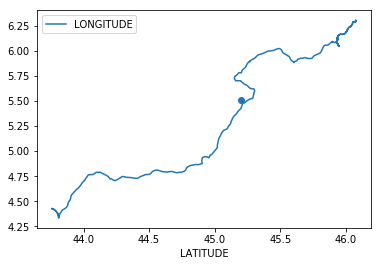

In [9]:
gps_df_flt.plot(x='LATITUDE',y='LONGITUDE')
ax = plt.gca()
ax.scatter(gps_df['LATITUDE'].mean(),gps_df['LONGITUDE'].mean());

Aggregation to reduce amount of data points 

In [10]:
gps_df_agg = gps_df_flt.resample('5Min').mean()
gps_df_agg = gps_df_agg.dropna()

Put markers on top of a map 

In [11]:
center = (gps_df['LATITUDE'].mean(),gps_df['LONGITUDE'].mean())
m = Map(center=center, zoom=8)

for key, val in gps_df_agg.iterrows():
    center = (val['LATITUDE'],val['LONGITUDE'])
    marker = Marker(location=center, draggable=False)
    m.add_layer(marker);

m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [12]:

# Place map
gmap = gmplot.GoogleMapPlotter(gps_df['LATITUDE'].mean(), gps_df['LONGITUDE'].mean(), zoom = 9)

# Polygon
gmap.plot(gps_df['LATITUDE'], gps_df['LONGITUDE'], 'cornflowerblue', edge_width=5)


# Draw
gmap.draw("../output/my_map.html")

Plot altitude 

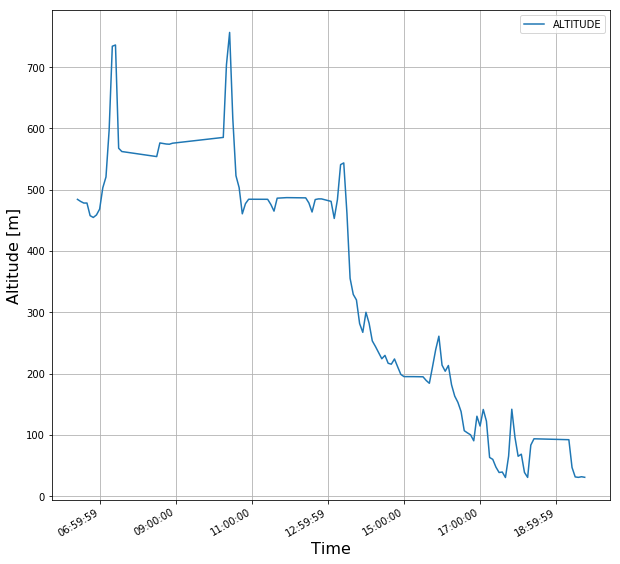

In [13]:
def transform_timestamp(matlab_datenum):
    """ Convert a date to datetime string """
    python_datetime = datetime.fromordinal(int(matlab_datenum)) + timedelta(days=matlab_datenum%1) - timedelta(days = 366)
    return python_datetime.strftime('%H:%M:%S')


gps_df_agg.plot(y='ALTITUDE', grid = True, figsize = (10,10))
plt.xlabel(r'Time',fontsize=16);
plt.ylabel(r'Altitude [m]',fontsize=16);
# Recover locs 
locs, labels = plt.xticks();
plt.xticks(locs,map(transform_timestamp,locs));

# plt.savefig('../output/height.pdf',format='pdf', bbox_inches='tight')